# Test of ESIS Reproducibility
_Roy Smart and Charles Kankelborg_

Set up environment and import required packages.

In [1]:
%matplotlib notebook
%reload_ext autoreload
%autoreload 2

import warnings
import matplotlib.pyplot as plt
import matplotlib.colors
import astropy.units as u
import pandas as pd
import kgpy.optics
import kgpy.vector
import esis

warnings.filterwarnings('ignore')

In [2]:
pupil_samples = 20
field_samples = 6

esis_optics_small = esis.optics.design.final(pupil_samples=7, field_samples=5)
esis_optics = esis.optics.design.final(pupil_samples=pupil_samples, field_samples=field_samples)

In [3]:
new_esis_optics = esis.optics.design.final_from_poletto(
    pupil_samples=pupil_samples, 
    field_samples=field_samples,
    use_toroidal_grating=False,
    use_vls_grating=True,
    use_one_wavelength_detector_tilt=True,
)
new_esis_optics_small = new_esis_optics.copy()
new_esis_optics_small.pupil_samples = esis_optics_small.pupil_samples
new_esis_optics_small.field_samples = esis_optics_small.field_samples
new_esis_optics_small.update()

## Layout

<IPython.core.display.Javascript object>


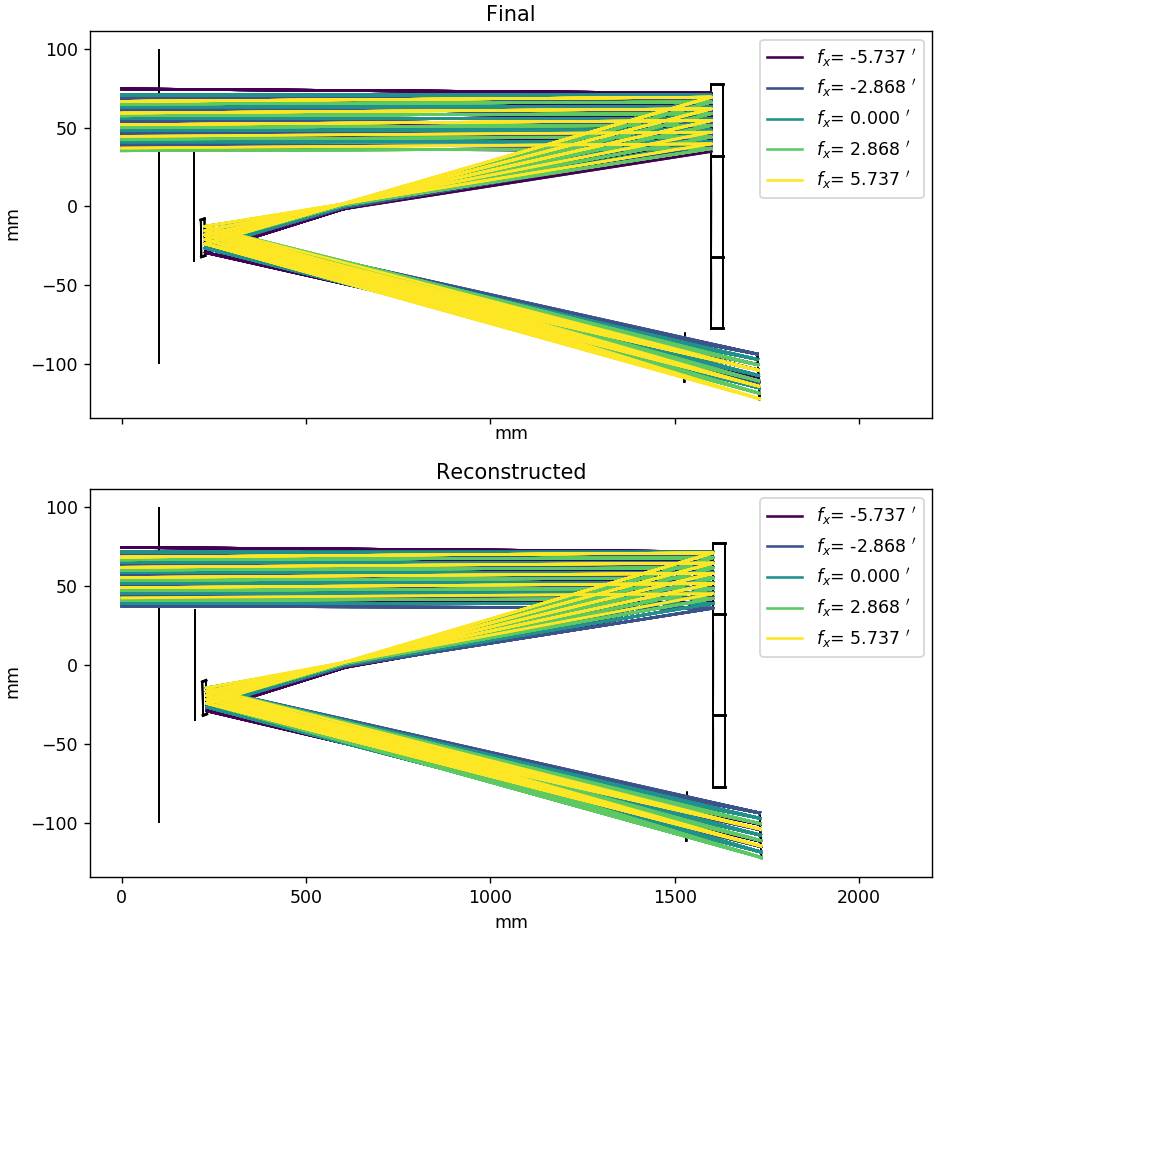

In [4]:
name_old = 'Final'
name_new = 'Reconstructed'
color_axis = kgpy.optics.Rays.axis.field_x
fig_layout, axs_layout = plt.subplots(
    nrows=2, 
    figsize=(7.5, 7.5), 
    
    constrained_layout=True,
    sharex=True,
    sharey=True,
)
_ = esis_optics_small.system.plot_2d(
    ax=axs_layout[0],
    components=(kgpy.vector.iz, kgpy.vector.ix),
    color_axis=color_axis,
)
_ = new_esis_optics_small.system.plot_2d(
    ax=axs_layout[1],
    components=(kgpy.vector.iz, kgpy.vector.ix),
    color_axis=color_axis,
)
_ = axs_layout[0].set_title(name_old)
_ = axs_layout[1].set_title(name_new)
# _ = axs_layout[0].axis('equal')
# _ = axs_layout[1].axis('equal')

<IPython.core.display.Javascript object>


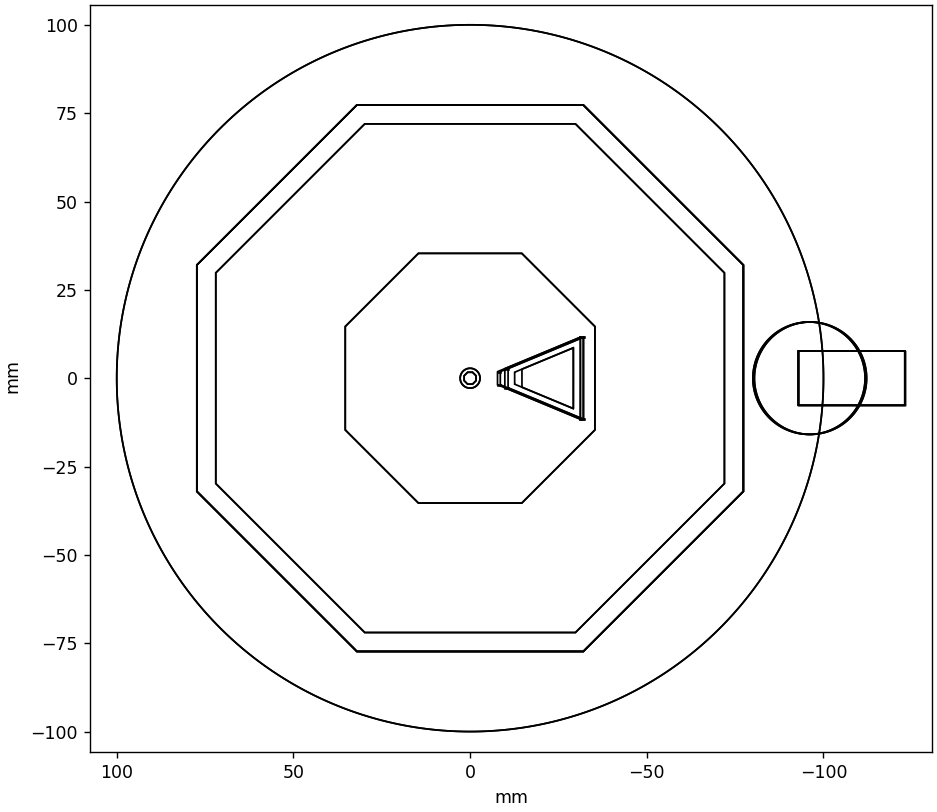

In [5]:
fig_bore, ax_bore = plt.subplots(
    figsize=(7.5, 6.5), 
    constrained_layout=True,
)
ax_bore.invert_xaxis()
_ = esis_optics_small.system.plot_2d(
    ax=ax_bore,
    plot_rays=False,
)
_ = new_esis_optics_small.system.plot_2d(
    ax=ax_bore,
    plot_rays=False,
)
_ = ax_bore.axis('equal')

In [6]:
c_old = esis_optics.components
c_new = new_esis_optics.components

## Front Aperture Plate

In [7]:
c_old.front_aperture.name = name_old
c_new.front_aperture.name = name_new
pd.concat([c_old.front_aperture.dataframe, c_new.front_aperture.dataframe], axis='columns')

,Final,Reconstructed
piston,1500.000 $\mathrm{mm}$,1505.347 $\mathrm{mm}$
clear radius,100.000 $\mathrm{mm}$,100.000 $\mathrm{mm}$


<IPython.core.display.Javascript object>


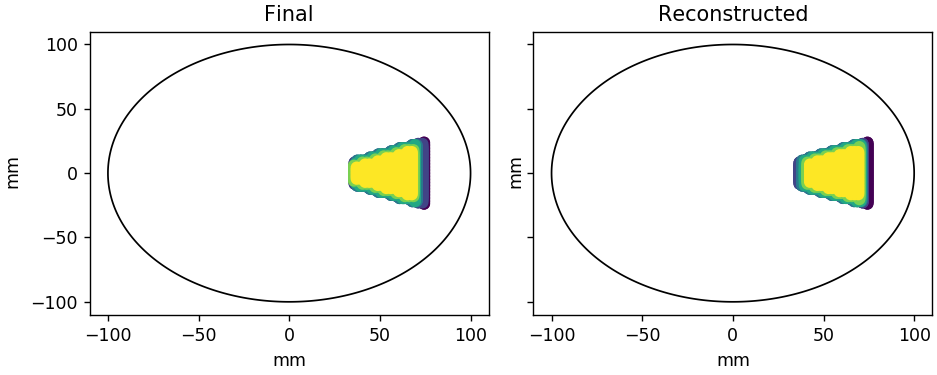

In [8]:
fig_front_aper, axs_front_aper = plt.subplots(
    ncols=2, 
    figsize=(7.5, 3), 
    constrained_layout=True,
    sharex=True,
    sharey=True,
)
_ = esis_optics.system.plot_footprint(
    ax=axs_front_aper[0],
    surf=esis_optics.components.front_aperture.surface,
    color_axis=color_axis,
)
_ = new_esis_optics.system.plot_footprint(
    ax=axs_front_aper[1],
    surf=new_esis_optics.components.front_aperture.surface,
    color_axis=color_axis,
)
axs_front_aper[0].get_legend().remove()
axs_front_aper[1].get_legend().remove()
_ = axs_front_aper[0].set_title(name_old)
_ = axs_front_aper[1].set_title(name_new)

## Central Obscuration

In [9]:
c_old.central_obscuration.name = name_old
c_new.central_obscuration.name = name_new
pd.concat([c_old.central_obscuration.dataframe, c_new.central_obscuration.dataframe], axis='columns')

,Final,Reconstructed
piston,1404.270 $\mathrm{mm}$,1405.347 $\mathrm{mm}$
obscured radius,38.223 $\mathrm{mm}$,38.256 $\mathrm{mm}$
number of sides,8,8


<IPython.core.display.Javascript object>


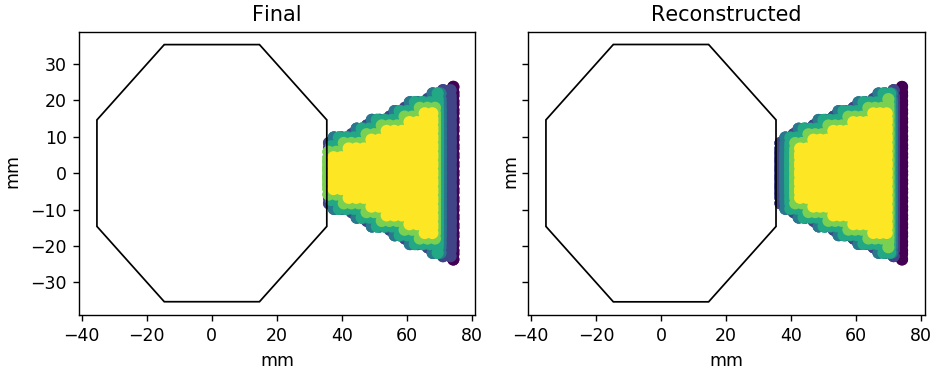

In [10]:
fig_obscuration, axs_obscuration = plt.subplots(
    ncols=2, 
    figsize=(7.5, 3), 
    constrained_layout=True,
    sharex=True,
    sharey=True,
)
_ = esis_optics.system.plot_footprint(
    ax=axs_obscuration[0],
    surf=esis_optics.components.central_obscuration.surface,
    color_axis=color_axis,
)
_ = new_esis_optics.system.plot_footprint(
    ax=axs_obscuration[1],
    surf=new_esis_optics.components.central_obscuration.surface,
    color_axis=color_axis,
)
axs_obscuration[0].get_legend().remove()
axs_obscuration[1].get_legend().remove()
_ = axs_obscuration[0].set_title(name_old)
_ = axs_obscuration[1].set_title(name_new)

## Primary Mirror

In [11]:
c_old.primary.name = name_old
c_new.primary.name = name_new
pd.concat([c_old.primary.dataframe, c_new.primary.dataframe], axis='columns')

,Final,Reconstructed
radius,2000.000 $\mathrm{mm}$,2000.000 $\mathrm{mm}$
conic constant,-1.000 $\mathrm{}$,-1.000 $\mathrm{}$
number of sides,8,8
clear radius,77.900 $\mathrm{mm}$,77.900 $\mathrm{mm}$
border width,5.800 $\mathrm{mm}$,5.800 $\mathrm{mm}$
substrate thickness,30.000 $\mathrm{mm}$,30.000 $\mathrm{mm}$


<IPython.core.display.Javascript object>


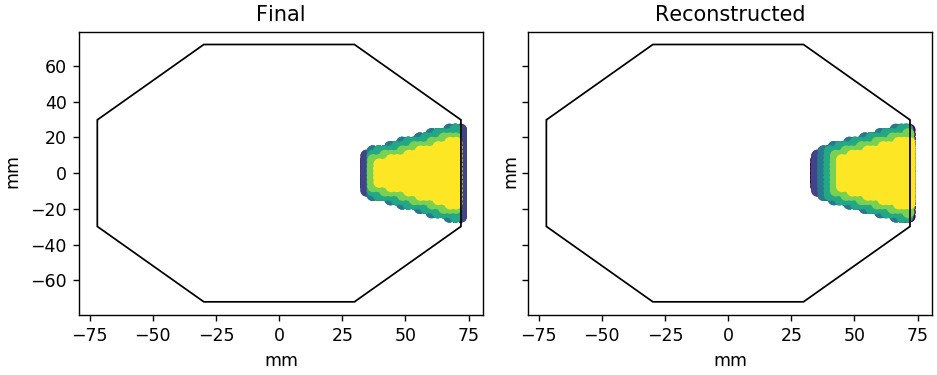

In [12]:
fig_primary, axs_primary = plt.subplots(
    ncols=2, 
    figsize=(7.5, 3), 
    constrained_layout=True,
    sharex=True,
    sharey=True,
)
_ = esis_optics.system.plot_footprint(
    ax=axs_primary[0],
    surf=esis_optics.components.primary.surface,
    color_axis=color_axis,
)
_ = new_esis_optics.system.plot_footprint(
    ax=axs_primary[1],
    surf=new_esis_optics.components.primary.surface,
    color_axis=color_axis,
)
axs_primary[0].get_legend().remove()
axs_primary[1].get_legend().remove()
_ = axs_primary[0].set_title(name_old)
_ = axs_primary[1].set_title(name_new)

## Field Stop

In [13]:
c_old.field_stop.name = name_old
c_new.field_stop.name = name_new
pd.concat([c_old.field_stop.dataframe, c_new.field_stop.dataframe], axis='columns')

,Final,Reconstructed
piston,1000.000 $\mathrm{mm}$,1000.000 $\mathrm{mm}$
clear radius,1.820 $\mathrm{mm}$,1.822 $\mathrm{mm}$
mechanical radius,2.810 $\mathrm{mm}$,2.810 $\mathrm{mm}$
number of sides,8,8


<IPython.core.display.Javascript object>


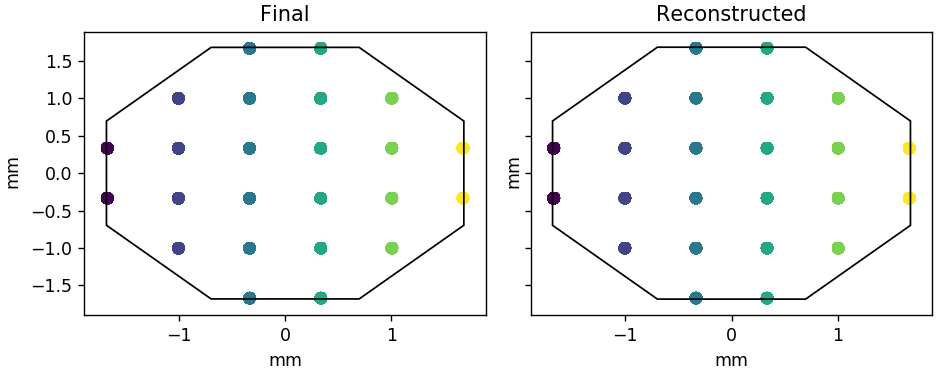

In [14]:
fig_field_stop, axs_field_stop = plt.subplots(
    ncols=2, 
    figsize=(7.5, 3), 
    constrained_layout=True,
    sharex=True,
    sharey=True,
)
_ = esis_optics.system.plot_footprint(
    ax=axs_field_stop[0],
    surf=esis_optics.components.field_stop.surface,
    color_axis=color_axis,
)
_ = new_esis_optics.system.plot_footprint(
    ax=axs_field_stop[1],
    surf=new_esis_optics.components.field_stop.surface,
    color_axis=color_axis,
)
axs_field_stop[0].get_legend().remove()
axs_field_stop[1].get_legend().remove()
_ = axs_field_stop[0].set_title(name_old)
_ = axs_field_stop[1].set_title(name_new)

## Grating

In [15]:
c_old.grating.name = name_old
c_new.grating.name = name_new
pd.concat([c_old.grating.dataframe, c_new.grating.dataframe], axis='columns')

,Final,Reconstructed
tangential radius,597.830 $\mathrm{mm}$,598.552 $\mathrm{mm}$
sagittal radius,597.830 $\mathrm{mm}$,598.552 $\mathrm{mm}$
nominal alpha,1.301 $\mathrm{{}^{\circ}}$,2.134 $\mathrm{{}^{\circ}}$
nominal beta,8.057 $\mathrm{{}^{\circ}}$,8.565 $\mathrm{{}^{\circ}}$
diffraction order,1 $\mathrm{}$,1 $\mathrm{}$
nominal groove density,2.587 $\mathrm{\frac{1}{\mu m}}$,3.067 $\mathrm{\frac{1}{\mu m}}$
groove density linear coefficient,2.265e-07 $\mathrm{\frac{1}{\mu m^{2}}}$,3.034e-07 $\mathrm{\frac{1}{\mu m^{2}}}$
groove density quadratic coefficient,9.314e-13 $\mathrm{\frac{1}{\mu m^{3}}}$,0.000e+00 $\mathrm{\frac{1}{\mu m^{3}}}$
groove density cubic coefficient,0.000 $\mathrm{\frac{1}{\mu m^{4}}}$,0.000 $\mathrm{\frac{1}{\mu m^{4}}}$
piston,1374.700 $\mathrm{mm}$,1375.777 $\mathrm{mm}$


<IPython.core.display.Javascript object>


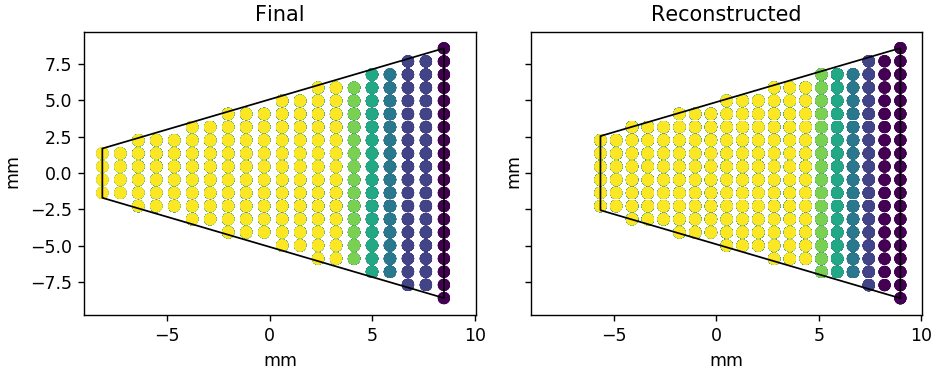

In [16]:
fig_grating, axs_grating = plt.subplots(
    ncols=2, 
    figsize=(7.5, 3), 
    constrained_layout=True,
    sharex=True,
    sharey=True,
)
_ = esis_optics.system.plot_footprint(
    ax=axs_grating[0],
    surf=esis_optics.components.grating.surface,
    color_axis=color_axis,
)
_ = new_esis_optics.system.plot_footprint(
    ax=axs_grating[1],
    surf=new_esis_optics.components.grating.surface,
    color_axis=color_axis,
)
axs_grating[0].get_legend().remove()
axs_grating[1].get_legend().remove()
_ = axs_grating[0].set_title(name_old)
_ = axs_grating[1].set_title(name_new)

## Filter

In [17]:
c_old.filter.name = name_old
c_new.filter.name = name_new
pd.concat([c_old.filter.dataframe, c_new.filter.dataframe], axis='columns')

,Final,Reconstructed
piston,73.038 $\mathrm{mm}$,73.038 $\mathrm{mm}$
channel radius,95.900 $\mathrm{mm}$,96.327 $\mathrm{mm}$
channel angle,180.000 $\mathrm{{}^{\circ}}$,180.000 $\mathrm{{}^{\circ}}$
inclination,-3.450 $\mathrm{{}^{\circ}}$,-3.340 $\mathrm{{}^{\circ}}$
clear radius,15.900 $\mathrm{mm}$,15.900 $\mathrm{mm}$
border width,0.000 $\mathrm{mm}$,0.000 $\mathrm{mm}$


<IPython.core.display.Javascript object>


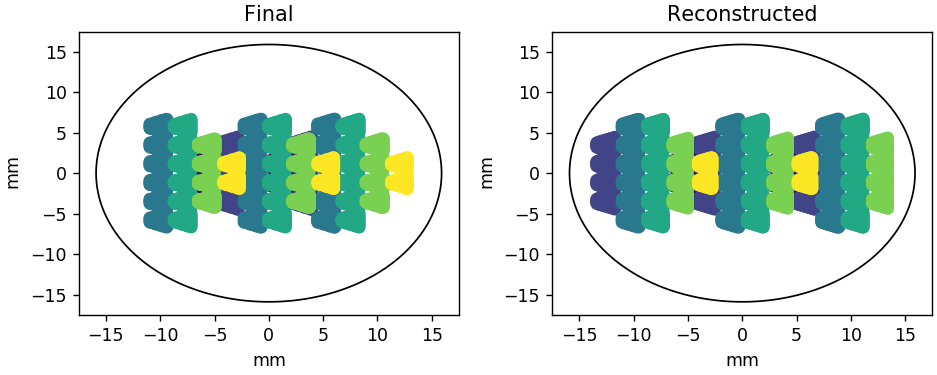

In [18]:
fig_filter, axs_filter = plt.subplots(ncols=2, figsize=(7.5, 3), constrained_layout=True)
_ = esis_optics.system.plot_footprint(
    ax=axs_filter[0],
    surf=esis_optics.components.filter.surface,
    color_axis=color_axis,
)
_ = new_esis_optics.system.plot_footprint(
    ax=axs_filter[1],
    surf=new_esis_optics.components.filter.surface,
    color_axis=color_axis,
)
axs_filter[0].get_legend().remove()
axs_filter[1].get_legend().remove()
_ = axs_filter[0].set_title(name_old)
_ = axs_filter[1].set_title(name_new)

## Detector

In [19]:
c_old.detector.name = name_old
c_new.detector.name = name_new
pd.concat([c_old.detector.dataframe, c_new.detector.dataframe], axis='columns')

,Final,Reconstructed
piston,-126.962 $\mathrm{mm}$,-126.962 $\mathrm{mm}$
channel radius,108.000 $\mathrm{mm}$,108.000 $\mathrm{mm}$
channel angle,180.000 $\mathrm{{}^{\circ}}$,180.000 $\mathrm{{}^{\circ}}$
inclination,-12.252 $\mathrm{{}^{\circ}}$,-8.876 $\mathrm{{}^{\circ}}$
pixel x half-width,7.500 $\mathrm{\mu m}$,7.500 $\mathrm{\mu m}$
pixel y half-width,7.500 $\mathrm{\mu m}$,7.500 $\mathrm{\mu m}$
number of pixels along x,2048,2048
number of pixels along y,1024,1024
right border width,0.000 $\mathrm{mm}$,0.000 $\mathrm{mm}$
left border width,0.000 $\mathrm{mm}$,0.000 $\mathrm{mm}$


<IPython.core.display.Javascript object>


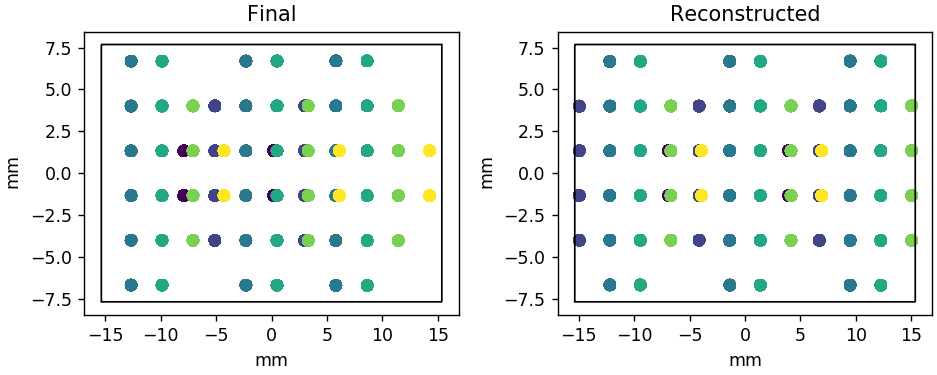

In [20]:
fig_detector, axs_detector = plt.subplots(ncols=2, figsize=(7.5, 3), constrained_layout=True)
_ = esis_optics.system.plot_footprint(
    ax=axs_detector[0],
    surf=esis_optics.components.detector.surface,
    color_axis=color_axis,
)
_ = new_esis_optics.system.plot_footprint(
    ax=axs_detector[1],
    surf=new_esis_optics.components.detector.surface,
    color_axis=color_axis,
)
axs_detector[0].get_legend().remove()
axs_detector[1].get_legend().remove()
_ = axs_detector[0].set_title(name_old)
_ = axs_detector[1].set_title(name_new)

## Spot diagrams for final ESIS design

<IPython.core.display.Javascript object>


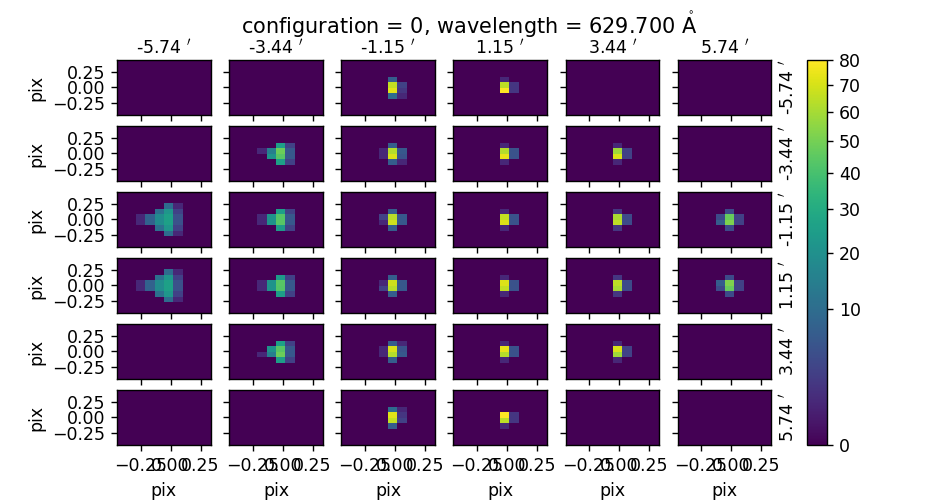

<IPython.core.display.Javascript object>


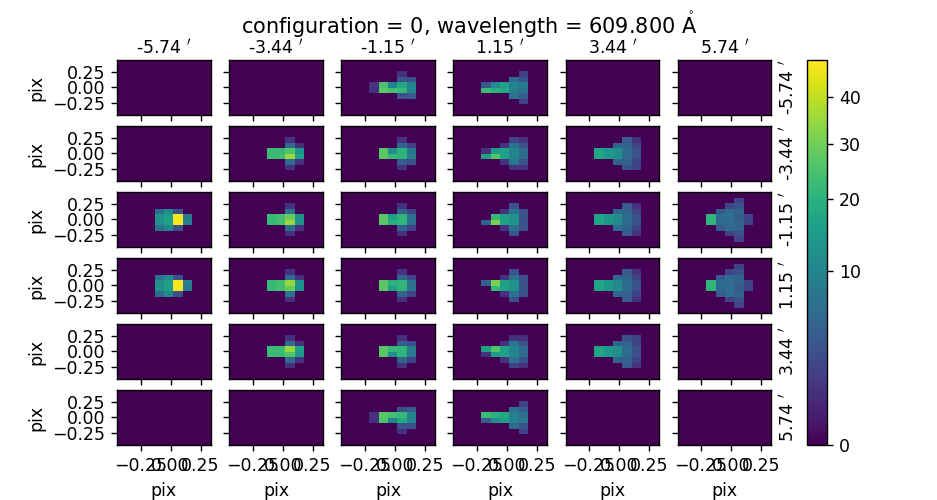

<IPython.core.display.Javascript object>


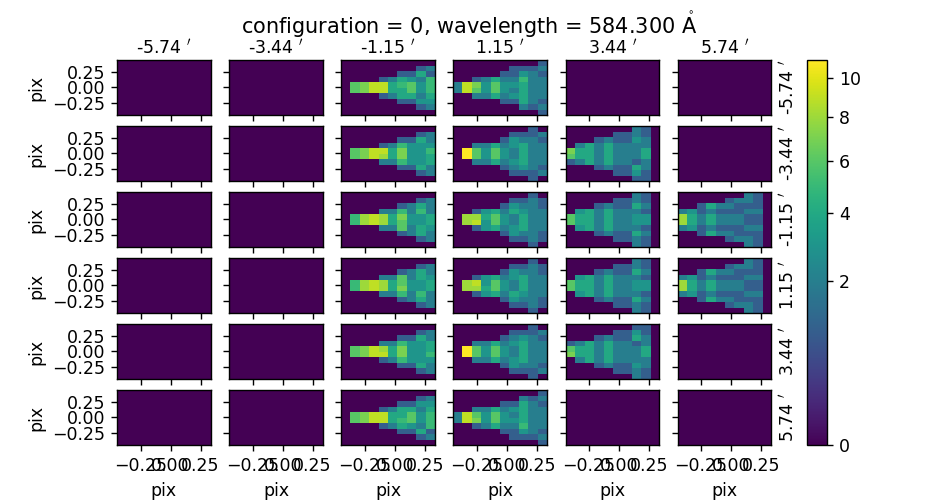

In [21]:
rays = esis_optics.system.rays_output.copy()
rays.position = (rays.position / (2 * esis_optics.components.detector.pix_half_width_x / u.pix)).to(u.pix)
for w in range(rays.input_grids[rays.axis.wavelength].shape[~0]):
    fig = rays.plot_pupil_hist2d_vs_field(
        wavlen_index=w,
        relative_to_centroid=(True, True),
        norm=matplotlib.colors.PowerNorm(1/2),
    )
    fig.set_figheight(4)
    fig.set_figwidth(7.5)

## Spot diagrams for reconstructed ESIS design

<IPython.core.display.Javascript object>


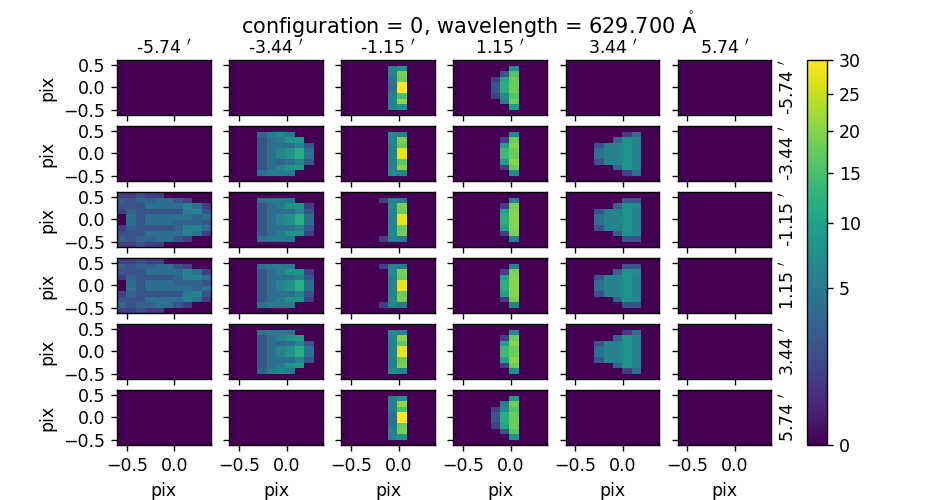

<IPython.core.display.Javascript object>


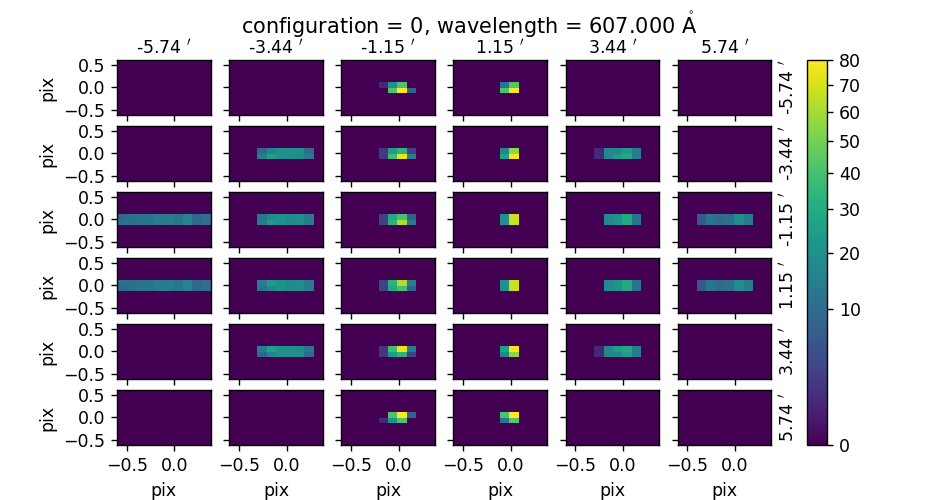

<IPython.core.display.Javascript object>


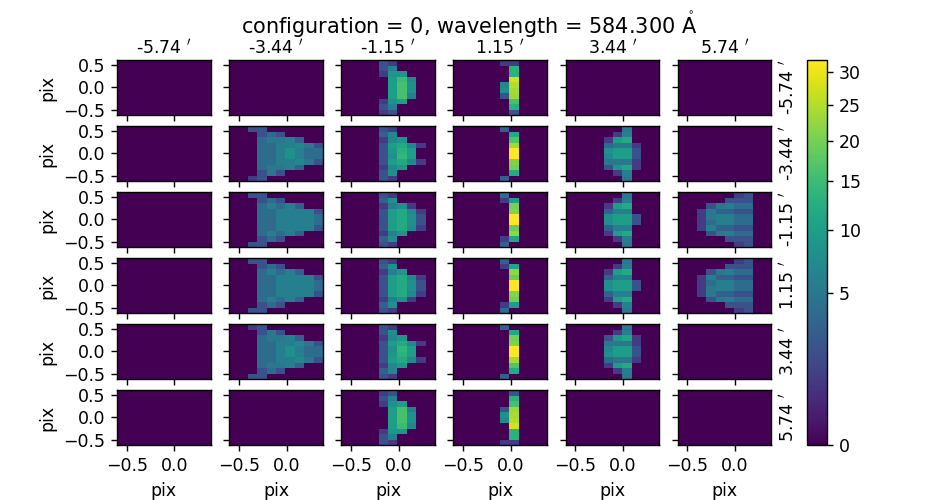

In [22]:
rays = new_esis_optics.system.rays_output.copy()
rays.position = (rays.position / (2 * esis_optics.components.detector.pix_half_width_x / u.pix)).to(u.pix)
for w in range(rays.input_grids[rays.axis.wavelength].shape[~0]):
    fig = rays.plot_pupil_hist2d_vs_field(
        wavlen_index=w,
        relative_to_centroid=(True, True),
        norm=matplotlib.colors.PowerNorm(1/2),
    )
    fig.set_figheight(4)
    fig.set_figwidth(7.5)


In [23]:
new_esis_optics.field_half_width

<Quantity [5.73673992, 5.73673992] arcmin>

In [24]:
esis_optics.field_half_width

<Quantity [5.7366, 5.7366, 0.    ] arcmin>

In [25]:
new_esis_optics.field_samples

6